# Projet Optimisation Groupe 6
### Hennion Corentin & Bourdin Mathis
Dans cette deuxième partie nous étuidierons plus spécifiquement le problème trouvé dans la première partie et proposerons une résolution numérique de ce dernier

#### 1er Question : Etude

Le problème établi en partie 1 $\max_{Cp\leq d} \frac{1}{2}p^TAp - b^Tp$ revient à résoudre le problème de minimisation sous contraintes $\min_{Cp\leq d} \frac{1}{2}p^TAp - b^Tp$.

Posons $f(p) = \frac{1}{2} p^TAp - b^Tp$ la fonction à minimiser sous la contrainte $c(p) = c^Tp - d$.

La fonction f est deux fois différentiable puisque c'est une fonction quadratique :

Le gradient est obtenu aidément grace au caractère symétrique de A :$\nabla f(p) = \frac{A+A^T}{2} p - b = Ap - b$.

$\nabla^2 f(p) = A > 0$ car A est symétrique définie positive, donc f est convexe.

Par ailleurs, la contrainte est affine.

Pour montrer l'existence et l'unicité de la solution du problème, montrons que f est fortement convexe :

Soient x et y deux vecteurs de $R^4_+$,

\begin{equation*}
\begin{aligned}
(\nabla f(x)^T - \nabla f(y)^T)(x - y) &= (x^TA^T - y^TA^T)(x-y)\\
								&= (x - y)^T A (x - y)\\
								&\geq || A || . || x - y ||^2\\
\end{aligned}
\end{equation*}								
Donc f est fortement convexe sur un domaine convexe, donc il existe une unique solution au problème de minimisation.

#### 2e Question : Resolution numérique

Nous commencons par importer les biblihoteques nécessaires à la résolution et à la déclaration des constantes du problèmes, cest à dire les matrices et fonctions nécessaires. 

In [1]:
import numpy as np #Pour le calcul matriciel
import matplotlib.pyplot as plt #Pour l'affichage des résultats
from time import time #Pour mesurer le temps d'éxécution

In [2]:
def timeit(func):
    def new_func(*args, **kwargs):
        init_time = time()
        res = func(*args, **kwargs)
        print("{0:10s} : {1:5f}s.".format(func.__name__, time()-init_time))
        return res
    return new_func
#Ce décorateur sert à mesurer le temps d'éxécution de la résoltuion.

A = np.array([[3.0825,0    ,0     ,0     ],
              [0     ,.0405,0     ,0     ],
              [0     ,0    ,.0271 ,-.0031],
              [0     ,0    ,-.0031,.0054 ]], dtype="float32").T
#On déclare ici A.T pour avoir l'exact A du problème par rigueur.
#Cela n'a aucune influence sur le problème puisque A est syémtrique

b = np.array([2671,135,103,19], dtype="float32")

C = np.array([[-.0401,-.0162,-.0039,.0002 ],
              [-.1326,-.0004,-.0034,.0006 ],
              [1.5413,0     ,0     ,0     ],
              [0     ,.0203 ,0     ,0     ],
              [0     ,0     ,.0136 ,-.0015],
              [0     ,0     ,-.0016,.0027 ],
              [.0160 ,.0004 ,.0005 ,.0002 ]], dtype="float32")

d = np.array([-92.6,-29,2671,135,103,19,10], dtype="float32")

def f(x):
    return -(b@x-0.5*x@A@x)

def df(x):
    return A@x-b

def c(x):
    return C@x-d

def dc(x):
    return C

Afin de résoudre ce problème, nous avons commencé par utiliser l'algorithme d'Arrow-Hurwicz puisque celui ci est simple à mettre en place et est léger en calcul par itération. Ensuite en fonction des résultats nous aviserons sur un éventuel passage sur un nouvel algorithme plus performant. Mais ci celui-ci donne de bons résultats, il serait inutile de changer d'algorithme.

Nous déclarons donc dans un premier temps les hyper-paramètres de cet algorithme :

In [3]:
x0 = np.array([2055,54,63,17])
#Celui-ci peut être pris aléatoirement mais l'approximation de l'année connue est un heuristique que nous imaginons acceptable. 
#Cela devrait permettre d'économiser quelques itérations.

lambd0 = np.random.rand(7) 
#Lambda est lui pris purement aléatoirement, nos tests n'ont pas montré d'influence sur la convergence si on change sa valeur.

eps = .1
alpha = .1
#Pour alpha et epsilon, les valeurs prises sont celles qui semblait usuellement utilisées.
#Changer leur valeurs n'as pas l'air d'influer grandement al convergence

diff = 1 #Ecart entre les xk
ite = 0 #Nombre d'itérations
acc = 1e-5 #Estimateur de la precision

Solution à 1013787 itérations : [ 420.33297615 4024.68195345 2775.30833067 1395.09462929].
resolve    : 23.708561s.


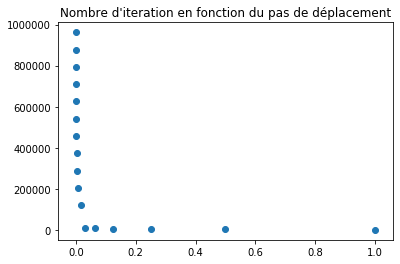

In [4]:
@timeit
def resolve():
    global x0, lambd0, diff, ite
    diffs = [diff]
    diffs_iter = [0]
    while diff > acc:
        xk     = x0 - eps*(df(x0) + dc(x0).T@lambd0)
        lambdk = lambd0+alpha*c(xk)
        lambdk = np.where(lambdk>=0, lambdk, 0)
        diff = np.linalg.norm(xk-x0)
        x0, lambd0 = xk, lambdk
        ite += 1
        if diff<diffs[-1]/2:
            diffs.append(diff)
            diffs_iter.append(ite)
        
    fig, ax = plt.subplots()
    ax.scatter(diffs, diffs_iter)
    ax.set_title("Nombre d'iteration en fonction du pas de déplacement")
    print("Solution à {} itérations : {}.".format(ite,xk))
    
resolve()

On observe immédatiement que le nombre d'itération éxplose avec le précision du pas de déplacement. Atteindre le million d'itération pour un pas de déplacement de 1e-5 c'est très élévé. Cependant, les itérations ne possède que peu de calculs donc cela se calcule relativement vite (20s sur l'ordinateur utilisé). On peut penser que cela vient de la grande hétérogénéité dans les ordres de grandeurs des poids des matrices.
Cet algorithme est donc pertinent dans notre cas si nous ne désirons pas d'une précision immense sur notre solution, cela nous couterait trop en nombre d'itérations. Afin d'avoir une précision plus élevée on pourrait imaginer un algorithme avec un pas variable plus poussé.

Pour le résultat on observe que le prix du lait chute tandis que celui des autres produits explose.
En quantité nous obtenus (Calcul fait à partir des relations obtenues par le tableau I):
x1 = 2023
x2 = 53
x3 = 67
x4 = 20
On remarque également de grandes différences sur les quantités. L'interpretation la plus évidente est donc que le gouvernement devrait se focaliser sur la vente de lait en réduisant fortement celle des autres, c'est ce produit qui rapporte le plus.